(a) Setup: load in data

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
train=pd.read_csv("20ng-train-all-terms.txt",header=None,sep='\t')
test=pd.read_csv("20ng-test-all-terms.txt",header=None,sep='\t')
X_train=train.drop(columns=[0])
Y_train=train[0]
X_test=test.drop(columns=[0])
Y_test=test[0]
n = len(Y_train) # num of documents

(b) Vocabulary Selection

b1: count frequency of y

In [4]:
#print(len(Y_train))
y_cnt=Counter()
for word in Y_train:
    y_cnt[word]+=1
y_cnt=dict(y_cnt)
print(y_cnt)

{'alt.atheism': 480, 'comp.graphics': 584, 'comp.os.ms-windows.misc': 572, 'comp.sys.ibm.pc.hardware': 590, 'comp.sys.mac.hardware': 578, 'comp.windows.x': 593, 'misc.forsale': 585, 'rec.autos': 594, 'rec.motorcycles': 598, 'rec.sport.baseball': 597, 'rec.sport.hockey': 600, 'sci.crypt': 595, 'sci.electronics': 591, 'sci.med': 594, 'sci.space': 593, 'soc.religion.christian': 598, 'talk.politics.guns': 545, 'talk.politics.mideast': 564, 'talk.politics.misc': 465, 'talk.religion.misc': 377}


b2: count frequency of Xi and frequency of (Xi,y)

In [5]:
text_dict = {}
line_dict = {}
word_dict = {}
xy_dict = {}
labels=list(y_cnt.keys())
class_type=np.asarray(labels)
class_idx=0
with open('20ng-train-all-terms.txt', "r") as file:
    for line in file:
        words = line.split()  
        if class_type[class_idx] not in words:
                xy_dict[class_idx]=word_dict  # store
                class_idx+=1 # next class
                word_dict={} #clear
        for word in words:
            # count of Xi
            if not word in labels:
                if not word in line_dict:
                # do not repeatly read in words of same document
                    line_dict[word]=1 
                    if not word in text_dict:
                        text_dict[word]=1
                    else:
                        text_dict[word]+=1
                # count of (Xi,y)
                    if not word in word_dict:
                        word_dict[word]=1
                    else:
                        word_dict[word]+=1
                
        line_dict={}  # clear    
    xy_dict[class_idx]=word_dict


b3: calculate mutual information I(Xi,Y)

In [6]:
from math import log
I={}
for word in text_dict.keys():
    I_xy=0
    for i in range(20):
        if word in xy_dict[i].keys():
            # x=1
            I_xy+=xy_dict[i][word]/n*log(xy_dict[i][word]*n/(y_cnt[labels[i]]*text_dict[word]))
            # x=0
            I_xy+=(y_cnt[labels[i]]-xy_dict[i][word])/n*log((y_cnt[labels[i]]-xy_dict[i][word])*n/(y_cnt[labels[i]]*(n-text_dict[word])))
        else:
            # x=1
            I_xy+=1/n*log(1*n/(y_cnt[labels[i]]*text_dict[word]))
            # x=0
            I_xy+=(y_cnt[labels[i]]-1)/n*log((y_cnt[labels[i]]-1)*n/(y_cnt[labels[i]]*(n-text_dict[word])))

    I[word]=I_xy

b4: pick top 5000 and print top 10 words

In [7]:
best = sorted([(k,v) for (v,k) in I.items()], reverse=True)[:5000]
top5000=list()
for i in range(5000):
    top5000.append(best[i][1])

print('top 10 words:\n')
for i in range(10):
    print(best[i][1],'\n\t',best[i][0])


top 10 words:

windows 
	 0.10686813807134349
god 
	 0.10503865027332576
sale 
	 0.08494523759973754
clipper 
	 0.08155229980685975
dod 
	 0.08024679082953239
government 
	 0.08001049809736512
re 
	 0.07747101884500286
team 
	 0.07496542460072984
he 
	 0.07470989670117738
car 
	 0.07302192245590709


(c) Input Representation

c1: Method one

In [7]:
line_dict = {}
input1 = np.zeros((n,5000))
idx = 0
with open('20ng-train-all-terms.txt', "r") as file:
    for line in file:
        words = line.split()  
        for word in words:
            # count of Xi
            if word in top5000:
                if not word in line_dict:
                # do not repeatly read in words of same document
                    line_dict[word]=1 
                    index=top5000.index(word)
                    input1[idx][index]=1
        idx+=1       
        line_dict={}  # clear    
print(input1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


c2: Method two

In [9]:
line_dict = {}
input2 = np.ones((n,5000)) # initialize as 1 (max(1,0)=1)
idx = 0
with open('20ng-train-all-terms.txt', "r") as file:
    for line in file:
        words = line.split()  
        for word in words:
            # count of Xi
            if word in top5000:
                # do not repeatly read in words of same document
                index=top5000.index(word)
                input2[idx][index]+=1
        idx+=1       
print(input2)

[[ 1. 16.  1. ...  1.  1.  1.]
 [ 1. 56.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  2.  1. ...  1.  1.  1.]
 [ 1.  2.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]


c3: Method three

In [8]:
line_dict = {}
input3 = np.ones((n,5000)) # initialize
idx = 0
with open('20ng-train-all-terms.txt', "r") as file:
    for line in file:
        words = line.split()  
        for word in words:
            # count of Xi
            if word in top5000:
                # do not repeatly read in words of same document
                index=top5000.index(word)
                input3[idx][index]+=1
        idx+=1       
for i in range(n):
    for j in range(5000):
            input3[i][j]=float(log(input3[i][j]))
print(input3)

[[0.         2.77258872 0.         ... 0.         0.         0.        ]
 [0.         4.02535169 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.69314718 0.         ... 0.         0.         0.        ]
 [0.         0.69314718 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


test data

In [33]:
line_dict = {}
test = np.ones((len(Y_test),5000)) # initialize
idx = 0
with open('20ng-test-all-terms.txt', "r") as file:
    for line in file:
        words = line.split()  
        for word in words:
            # count of Xi
            if word in top5000:
                # do not repeatly read in words of same document
                index=top5000.index(word)
                test[idx][index]+=1
        idx+=1       
for i in range(len(Y_test)):
    for j in range(5000):
            test[i][j]=float(log(test[i][j]))
print(test)

[[0.         0.69314718 0.         ... 0.         0.         0.        ]
 [0.         0.69314718 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


c4: Label producing

In [12]:
tmp = Y_train[0]
output = np.zeros((n,1))
label = 0 # initialize as 0, should be 0,1,2,...,18,19
for i in range(1,n):
    if Y_train[i]!=tmp:
        label+=1 # add one when Y_train changes
        tmp=Y_train[i]
    output[i]=label  

test label

In [17]:
tmp = Y_test[0]
output_test = np.zeros((len(Y_test),1))
label = 0 # initialize as 0, should be 0,1,2,...,18,19
for i in range(1,len(Y_test)):
    if Y_test[i]!=tmp:
        label+=1 # add one when Y_train changes
        tmp=Y_test[i]
    output_test[i]=label 
y_test=output_test.ravel()

(d) SVM classifier

split the data into training data set and validation data set

In [13]:
from sklearn.model_selection import train_test_split
#X_train, X_valid, y_train, y_valid= train_test_split(input1,output,test_size=0.2, random_state=0)
#X_train, X_valid, y_train, y_valid= train_test_split(input2,output,test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(input3,output,test_size=0.2, random_state=0)
y_train=y_train.ravel()
y_valid=y_valid.ravel()

using different kernels:

In [ ]:
from sklearn.svm import SVC 
from sklearn.multiclass import OneVsRestClassifier
kernels = ['linear','rbf','poly']
accuracy = np.zeros((3,1))
for i in range(3):
    svm_model = OneVsRestClassifier(SVC(kernel=kernels[i], C = 1,gamma='auto')).fit(X_train, y_train)
    predict = svm_model.predict(X_valid) 
    accuracy[i] = svm_model.score(X_valid, y_valid) 
    print(kernels[i],'\n',accuracy[i],'\n')

using different penalty parameters C:

In [ ]:
from sklearn.svm import SVC 
from sklearn.multiclass import OneVsRestClassifier
c = [0.01, 0.05, 0.1, 0.5, 1]
accuracy = np.zeros((5,1))
for i in range(5):
    svm_model_linear = OneVsRestClassifier(SVC(kernel='linear',C=c[i])).fit(X_train, y_train)
    predict = svm_model_linear.predict(X_valid) 
    accuracy[i] = svm_model_linear.score(X_valid, y_valid) 
    print(c[i],'\n',accuracy[i],'\n')

0.01 
 [0.84683488] 



In [14]:
from sklearn.svm import SVC 
from sklearn.multiclass import OneVsRestClassifier
svm_model_linear = OneVsRestClassifier(SVC(kernel='linear',C=0.1)).fit(X_train, y_train)
#predict = svm_model_linear.predict(X_valid) 
#accuracy = svm_model_linear.score(X_valid, y_valid) 
#print('accuracy:','\n',accuracy)

(e) evaluate the model:

In [35]:
predict = svm_model_linear.predict(test) 
accuracy = svm_model_linear.score(test,y_test) 
print('accuracy:','\n',accuracy)

accuracy: 
 0.7562433581296493


In [36]:
predict = svm_model_linear.predict(test)

In [39]:
wrong_class={}
for i in range(len(predict)):
    if predict[i]!=y_test[i]:
        class_type=y_test[i]
        if class_type not in wrong_class:
            wrong_class[class_type]=1
        else:
            wrong_class[class_type]+=1
#sort
wrong = sorted([(k,v) for (v,k) in wrong_class.items()], reverse=True)
print(wrong)

[(164, 12.0), (152, 18.0), (145, 3.0), (134, 19.0), (131, 1.0), (122, 2.0), (117, 5.0), (108, 13.0), (102, 0.0), (99, 4.0), (95, 17.0), (78, 7.0), (65, 14.0), (58, 16.0), (57, 15.0), (53, 11.0), (51, 9.0), (46, 8.0), (38, 6.0), (20, 10.0)]


In [60]:
from nltk import ConfusionMatrix
matrix=ConfusionMatrix(list(y_test), list(predict))
print(matrix)

     |                                           1   1   1   1   1   1   1   1   1   1 |
     |   0   1   2   3   4   5   6   7   8   9   0   1   2   3   4   5   6   7   8   9 |
     |   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   . |
     |   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 |
-----+---------------------------------------------------------------------------------+
 0.0 |<217>  2   .   3   .   1   .   2   2   4   1   2   2   9   6  15   6   3   .  44 |
 1.0 |   5<258> 20  11  10  21  12   4   2   8   1   3  13   4   6   3   1   2   2   3 |
 2.0 |   1  32<272> 32  14  12   4   2   .   4   1   1   4   4   2   1   .   3   4   1 |
 3.0 |   .  15  31<247> 29  11  18   7   .   1   .   2  22   3   1   .   2   .   2   1 |
 4.0 |   2   8  10  35<286>  4   8   2   .   3   1   2  14   3   3   1   .   .   2   1 |
 5.0 |   2  35  27   7   8<275> 15   2   1   1   4   3   3   2   3   .   1   .   .   3 |
 6.0 |   .   5   1   

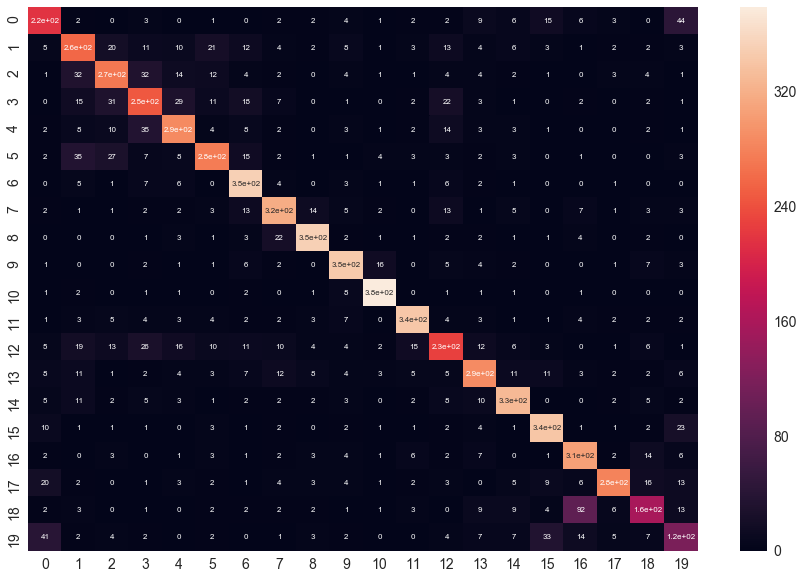

In [61]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
matrix = sklearn.metrics.confusion_matrix(y_test, predict)
df_cm = pd.DataFrame(matrix, range(20),range(20))
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size

In [85]:
weight = svm_model_linear.coef_
max_matrix = np.zeros((20,10))
min_matrix = np.zeros((20,10))
for i in range(10):
    max_matrix[:,i] = np.argmax(weight,axis=1)
    for j in range(20):
        index=int(max_matrix[j,i])
        weight[j,index]=0
for i in range(10):
    min_matrix[:,i] = np.argmin(weight,axis=1)
    for j in range(20):
        index=int(min_matrix[j,i])
        weight[j,index]=0
print('max matrix:\n',max_matrix,'\n')
print('min_matrix:\n',min_matrix,'\n')


max matrix:
 [[5.800e+01 1.890e+02 1.630e+02 2.500e+02 9.000e+01 8.890e+02 1.471e+03
  1.347e+03 1.009e+03 1.324e+03]
 [3.900e+01 1.343e+03 8.270e+02 1.764e+03 5.020e+02 2.132e+03 2.757e+03
  1.241e+03 2.826e+03 6.000e+02]
 [0.000e+00 3.500e+01 7.700e+02 2.220e+02 2.390e+02 6.700e+01 2.544e+03
  1.881e+03 1.851e+03 1.992e+03]
 [9.360e+02 2.170e+02 1.253e+03 2.480e+02 7.300e+01 2.264e+03 8.980e+02
  3.380e+02 1.882e+03 3.990e+02]
 [4.600e+01 6.200e+01 3.680e+02 7.570e+02 8.070e+02 1.346e+03 3.360e+02
  2.046e+03 9.230e+02 1.000e+03]
 [1.160e+02 1.500e+01 3.050e+02 2.010e+02 6.130e+02 6.000e+01 5.370e+02
  1.314e+03 1.864e+03 3.590e+02]
 [2.000e+00 4.170e+02 1.030e+02 2.444e+03 1.800e+02 9.060e+02 5.640e+02
  2.876e+03 2.597e+03 3.080e+02]
 [9.000e+00 5.000e+01 6.210e+02 9.570e+02 6.990e+02 7.440e+02 1.133e+03
  1.079e+03 2.580e+03 3.950e+02]
 [4.000e+00 1.200e+01 1.600e+02 1.860e+02 1.820e+02 6.190e+02 1.140e+03
  1.100e+02 9.200e+02 2.130e+02]
 [3.600e+01 5.740e+02 2.100e+03 4.250e+02 

In [19]:
print('max:\n')
for i in range(20):
    print(best[max_matrix[i][0]][1])
print('\nmin:\n')
for i in range(20):
    print(best[min_matrix[i][0]][1])

max:

atheists
graphics
windows
gateway
mac
motif
sale
car
dod
baseball
hockey
clipper
electronics
doctor
space
athos
gun
israel
kaldis
promise

min:

rutgers
mit
graphics
mac
controller
go
other
bike
car
hockey
runs
windows
mac
space
contact
kaldis
message
given
read
atheists
